In [100]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import os
from tqdm import tqdm

class SingleLayerNN(nn.Module):
    def __init__(self):
        super(SingleLayerNN, self).__init__()
        self.fc = nn.Linear(784, 512) 
        self.fc0 = nn.Linear(512, 256)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.relu(self.fc(x)) 
        x = torch.relu(self.fc0(x))
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.out(x)  
        return x

model = SingleLayerNN()


criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.01)  


In [101]:
#torch.manual_seed(7)

In [102]:
train_dataset = MNIST(os.getcwd(), train=True, download=True, transform=[transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
x_train = train_dataset.data / 255.0
y_train = F.one_hot(train_dataset.targets, num_classes=10)
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_train = x_train.view(-1, 784)
dtrain = torch.utils.data.TensorDataset(x_train, y_train)
trainloader = DataLoader(dtrain, batch_size=256, shuffle=True)

/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_62951/112231088.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32)
/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_62951/112231088.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)


In [103]:
testDataset = MNIST(os.getcwd(), train=False, download=True, transform=[transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
x_test = testDataset.data / 255.0
y_test = F.one_hot(testDataset.targets, num_classes=10)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
x_test = x_test.view(-1, 784)
dtest = torch.utils.data.TensorDataset(x_test, y_test)
testloader = DataLoader(dtest, batch_size=256, shuffle=True)

/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_62951/3473755828.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test, dtype=torch.float32)
/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_62951/3473755828.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32)


In [104]:
def neuronalNeuralBalance(inl, oul):

    ninc = torch.zeros_like(inl.weight)
    noul = torch.zeros_like(oul.weight)

    for i in range(inl.weight.data.shape[0]):
        inc = np.sqrt(torch.sum(torch.square(inl.weight.data[i])).item())
        outg = np.sqrt(torch.sum(torch.square(oul.weight.data[:,i])).item())

        # outg = outg / float(len(oul.weight.data[:,i]))
        # inc = inc / float(len(inl.weight.data[i]))

        opt = np.sqrt(outg/inc)

        ninc[i] = inl.weight.data[i]*opt
        noul[:, i] = oul.weight.data[:,i]/opt

    inl.weight.data = ninc
    oul.weight.data = noul


In [105]:
model = model
lay = []
for n, i in model.named_children():
    print(type(i).__name__)
    if type(i).__name__ == "Linear":
        lay.append((n, i))

acc = []

l2_lambda = 0.00001

num_epochs = 100  
for epoch in range(num_epochs):
    ttot = 0
    tcorr = 0
    for b in tqdm(trainloader):
        xt, y = b[0], b[1]
        optimizer.zero_grad() 
        outputs = model(xt)  
        loss = criterion(outputs, y) 

        l2_penalty = sum(torch.sum(p**2) for p in model.parameters())
        loss += l2_lambda * l2_penalty 
        
        loss.backward() 
        optimizer.step() 
    
        _, y = torch.max(y.data, 1)
        _, pred = torch.max(outputs.data, 1)
        ttot += y.shape[0]
        tcorr += (pred == y).sum().item()
    
    # for i in range(len(lay)):
    #     if i > 0 and i <= len(lay)-1:
    #         di = neuronalNeuralBalance(lay[i-1][1], lay[i][1])

    print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}, train dataset accuracy: {100*tcorr/ttot}')
        
    tot = 0
    corr = 0

    with torch.no_grad():
        for i in testloader:
            xt, y = i[0], i[1]
            outputs = model(xt)  
            _, y = torch.max(y.data, 1)
            _, pred = torch.max(outputs.data, 1)
            tot += y.shape[0]
            corr += (pred == y).sum().item()
    print(f'test dataset accuracy: {100*corr/tot}%')
    acc.append(corr/tot)


Linear
Linear
Linear
Linear
Linear


100%|██████████| 235/235 [00:01<00:00, 131.32it/s]


Epoch 0/100, Loss: 0.012234299443662167, train dataset accuracy: 78.47666666666667
test dataset accuracy: 94.25%


100%|██████████| 235/235 [00:01<00:00, 128.20it/s]


Epoch 1/100, Loss: 0.010575342923402786, train dataset accuracy: 95.31
test dataset accuracy: 95.42%


100%|██████████| 235/235 [00:01<00:00, 135.58it/s]


Epoch 2/100, Loss: 0.010051806457340717, train dataset accuracy: 95.845
test dataset accuracy: 96.08%


100%|██████████| 235/235 [00:01<00:00, 134.28it/s]


Epoch 3/100, Loss: 0.01096200942993164, train dataset accuracy: 96.02666666666667
test dataset accuracy: 95.45%


100%|██████████| 235/235 [00:01<00:00, 131.41it/s]


Epoch 4/100, Loss: 0.012699427083134651, train dataset accuracy: 96.12
test dataset accuracy: 95.76%


100%|██████████| 235/235 [00:01<00:00, 126.82it/s]


Epoch 5/100, Loss: 0.01132010668516159, train dataset accuracy: 96.19833333333334
test dataset accuracy: 96.15%


100%|██████████| 235/235 [00:01<00:00, 140.82it/s]


Epoch 6/100, Loss: 0.007732518948614597, train dataset accuracy: 96.25333333333333
test dataset accuracy: 95.64%


100%|██████████| 235/235 [00:01<00:00, 133.42it/s]


Epoch 7/100, Loss: 0.011147378012537956, train dataset accuracy: 96.15666666666667
test dataset accuracy: 96.34%


100%|██████████| 235/235 [00:01<00:00, 125.69it/s]


Epoch 8/100, Loss: 0.012546001002192497, train dataset accuracy: 96.51666666666667
test dataset accuracy: 95.99%


100%|██████████| 235/235 [00:01<00:00, 129.91it/s]


Epoch 9/100, Loss: 0.010480537079274654, train dataset accuracy: 96.375
test dataset accuracy: 96.03%


100%|██████████| 235/235 [00:01<00:00, 135.02it/s]


Epoch 10/100, Loss: 0.008196024224162102, train dataset accuracy: 96.385
test dataset accuracy: 95.94%


100%|██████████| 235/235 [00:01<00:00, 133.20it/s]


Epoch 11/100, Loss: 0.015420561656355858, train dataset accuracy: 96.49666666666667
test dataset accuracy: 95.75%


100%|██████████| 235/235 [00:01<00:00, 133.27it/s]


Epoch 12/100, Loss: 0.009219866245985031, train dataset accuracy: 96.42833333333333
test dataset accuracy: 95.89%


100%|██████████| 235/235 [00:01<00:00, 126.58it/s]


Epoch 13/100, Loss: 0.009186433628201485, train dataset accuracy: 96.52666666666667
test dataset accuracy: 96.07%


100%|██████████| 235/235 [00:01<00:00, 135.28it/s]


Epoch 14/100, Loss: 0.00939173810184002, train dataset accuracy: 96.455
test dataset accuracy: 95.6%


100%|██████████| 235/235 [00:01<00:00, 134.00it/s]


Epoch 15/100, Loss: 0.010377395898103714, train dataset accuracy: 96.40666666666667
test dataset accuracy: 96.37%


100%|██████████| 235/235 [00:01<00:00, 129.14it/s]


Epoch 16/100, Loss: 0.01085556112229824, train dataset accuracy: 96.43166666666667
test dataset accuracy: 96.19%


100%|██████████| 235/235 [00:01<00:00, 129.98it/s]


Epoch 17/100, Loss: 0.010149783454835415, train dataset accuracy: 96.50166666666667
test dataset accuracy: 96.15%


100%|██████████| 235/235 [00:01<00:00, 133.81it/s]


Epoch 18/100, Loss: 0.00908429455012083, train dataset accuracy: 96.58666666666667
test dataset accuracy: 95.92%


100%|██████████| 235/235 [00:01<00:00, 135.04it/s]


Epoch 19/100, Loss: 0.008273962885141373, train dataset accuracy: 96.50833333333334
test dataset accuracy: 95.76%


100%|██████████| 235/235 [00:01<00:00, 134.64it/s]


Epoch 20/100, Loss: 0.007878664880990982, train dataset accuracy: 96.59833333333333
test dataset accuracy: 96.37%


100%|██████████| 235/235 [00:01<00:00, 130.93it/s]


Epoch 21/100, Loss: 0.013950098305940628, train dataset accuracy: 96.515
test dataset accuracy: 96.23%


100%|██████████| 235/235 [00:01<00:00, 134.99it/s]


Epoch 22/100, Loss: 0.006644358858466148, train dataset accuracy: 96.52666666666667
test dataset accuracy: 95.88%


100%|██████████| 235/235 [00:01<00:00, 132.63it/s]


Epoch 23/100, Loss: 0.008687407709658146, train dataset accuracy: 96.52333333333333
test dataset accuracy: 95.83%


100%|██████████| 235/235 [00:01<00:00, 135.00it/s]


Epoch 24/100, Loss: 0.016467520967125893, train dataset accuracy: 96.69166666666666
test dataset accuracy: 96.11%


100%|██████████| 235/235 [00:01<00:00, 130.87it/s]


Epoch 25/100, Loss: 0.010216648690402508, train dataset accuracy: 96.54833333333333
test dataset accuracy: 96.72%


100%|██████████| 235/235 [00:01<00:00, 128.65it/s]


Epoch 26/100, Loss: 0.010824205353856087, train dataset accuracy: 96.70333333333333
test dataset accuracy: 94.99%


100%|██████████| 235/235 [00:01<00:00, 140.28it/s]


Epoch 27/100, Loss: 0.014044029638171196, train dataset accuracy: 96.61833333333334
test dataset accuracy: 95.69%


100%|██████████| 235/235 [00:01<00:00, 134.72it/s]


Epoch 28/100, Loss: 0.00901651568710804, train dataset accuracy: 96.72666666666667
test dataset accuracy: 96.13%


100%|██████████| 235/235 [00:01<00:00, 126.99it/s]


Epoch 29/100, Loss: 0.011629417538642883, train dataset accuracy: 96.65
test dataset accuracy: 95.9%


100%|██████████| 235/235 [00:01<00:00, 133.45it/s]


Epoch 30/100, Loss: 0.012201476842164993, train dataset accuracy: 96.55666666666667
test dataset accuracy: 96.24%


100%|██████████| 235/235 [00:01<00:00, 135.00it/s]


Epoch 31/100, Loss: 0.006565674673765898, train dataset accuracy: 96.67166666666667
test dataset accuracy: 96.48%


100%|██████████| 235/235 [00:01<00:00, 134.62it/s]


Epoch 32/100, Loss: 0.011261360719799995, train dataset accuracy: 96.7
test dataset accuracy: 96.33%


100%|██████████| 235/235 [00:01<00:00, 128.91it/s]


Epoch 33/100, Loss: 0.013973874971270561, train dataset accuracy: 96.725
test dataset accuracy: 95.87%


100%|██████████| 235/235 [00:01<00:00, 134.18it/s]


Epoch 34/100, Loss: 0.01586776226758957, train dataset accuracy: 96.515
test dataset accuracy: 96.12%


100%|██████████| 235/235 [00:01<00:00, 133.04it/s]


Epoch 35/100, Loss: 0.017628610134124756, train dataset accuracy: 96.595
test dataset accuracy: 96.1%


100%|██████████| 235/235 [00:01<00:00, 126.30it/s]


Epoch 36/100, Loss: 0.01109318993985653, train dataset accuracy: 96.7
test dataset accuracy: 96.31%


100%|██████████| 235/235 [00:01<00:00, 125.81it/s]


Epoch 37/100, Loss: 0.011545347049832344, train dataset accuracy: 96.52166666666666
test dataset accuracy: 96.4%


100%|██████████| 235/235 [00:01<00:00, 135.51it/s]


Epoch 38/100, Loss: 0.011050309985876083, train dataset accuracy: 96.57
test dataset accuracy: 96.44%


100%|██████████| 235/235 [00:01<00:00, 133.56it/s]


Epoch 39/100, Loss: 0.0143387820571661, train dataset accuracy: 96.82166666666667
test dataset accuracy: 96.65%


100%|██████████| 235/235 [00:01<00:00, 132.70it/s]


Epoch 40/100, Loss: 0.009780590422451496, train dataset accuracy: 96.67833333333333
test dataset accuracy: 96.55%


100%|██████████| 235/235 [00:01<00:00, 130.29it/s]


Epoch 41/100, Loss: 0.011111065745353699, train dataset accuracy: 96.59
test dataset accuracy: 96.4%


100%|██████████| 235/235 [00:01<00:00, 135.31it/s]


Epoch 42/100, Loss: 0.008607477881014347, train dataset accuracy: 96.55333333333333
test dataset accuracy: 96.36%


100%|██████████| 235/235 [00:01<00:00, 134.69it/s]


Epoch 43/100, Loss: 0.012505804188549519, train dataset accuracy: 96.65
test dataset accuracy: 95.58%


100%|██████████| 235/235 [00:01<00:00, 134.21it/s]


Epoch 44/100, Loss: 0.014300307258963585, train dataset accuracy: 96.615
test dataset accuracy: 96.77%


100%|██████████| 235/235 [00:01<00:00, 128.15it/s]


Epoch 45/100, Loss: 0.006152633111923933, train dataset accuracy: 96.68333333333334
test dataset accuracy: 96.54%


100%|██████████| 235/235 [00:01<00:00, 133.33it/s]


Epoch 46/100, Loss: 0.012106831185519695, train dataset accuracy: 96.73333333333333
test dataset accuracy: 96.06%


100%|██████████| 235/235 [00:01<00:00, 123.39it/s]


Epoch 47/100, Loss: 0.01053017657250166, train dataset accuracy: 96.67166666666667
test dataset accuracy: 95.63%


100%|██████████| 235/235 [00:01<00:00, 128.38it/s]


Epoch 48/100, Loss: 0.01842622645199299, train dataset accuracy: 96.48333333333333
test dataset accuracy: 95.72%


100%|██████████| 235/235 [00:01<00:00, 130.51it/s]


Epoch 49/100, Loss: 0.018761053681373596, train dataset accuracy: 96.815
test dataset accuracy: 96.38%


100%|██████████| 235/235 [00:01<00:00, 134.02it/s]


Epoch 50/100, Loss: 0.009332707151770592, train dataset accuracy: 96.62
test dataset accuracy: 95.84%


100%|██████████| 235/235 [00:01<00:00, 130.55it/s]


Epoch 51/100, Loss: 0.010459519922733307, train dataset accuracy: 96.66166666666666
test dataset accuracy: 95.0%


100%|██████████| 235/235 [00:01<00:00, 133.06it/s]


Epoch 52/100, Loss: 0.010743445716798306, train dataset accuracy: 96.62833333333333
test dataset accuracy: 96.51%


100%|██████████| 235/235 [00:01<00:00, 134.06it/s]


Epoch 53/100, Loss: 0.011533709242939949, train dataset accuracy: 96.785
test dataset accuracy: 95.49%


100%|██████████| 235/235 [00:01<00:00, 133.00it/s]


Epoch 54/100, Loss: 0.012064125388860703, train dataset accuracy: 96.645
test dataset accuracy: 96.72%


100%|██████████| 235/235 [00:01<00:00, 123.99it/s]


Epoch 55/100, Loss: 0.009450864046812057, train dataset accuracy: 96.66
test dataset accuracy: 95.7%


100%|██████████| 235/235 [00:01<00:00, 134.97it/s]


Epoch 56/100, Loss: 0.011697357520461082, train dataset accuracy: 96.71166666666667
test dataset accuracy: 96.33%


100%|██████████| 235/235 [00:01<00:00, 132.20it/s]


Epoch 57/100, Loss: 0.007783493958413601, train dataset accuracy: 96.61833333333334
test dataset accuracy: 95.43%


100%|██████████| 235/235 [00:01<00:00, 133.90it/s]


Epoch 58/100, Loss: 0.011709311977028847, train dataset accuracy: 96.73
test dataset accuracy: 96.21%


100%|██████████| 235/235 [00:01<00:00, 132.98it/s]


Epoch 59/100, Loss: 0.008696495555341244, train dataset accuracy: 96.82666666666667
test dataset accuracy: 96.41%


100%|██████████| 235/235 [00:01<00:00, 130.70it/s]


Epoch 60/100, Loss: 0.011745305731892586, train dataset accuracy: 96.69666666666667
test dataset accuracy: 95.84%


100%|██████████| 235/235 [00:01<00:00, 132.00it/s]


Epoch 61/100, Loss: 0.007558306213468313, train dataset accuracy: 96.64333333333333
test dataset accuracy: 96.32%


100%|██████████| 235/235 [00:01<00:00, 133.24it/s]


Epoch 62/100, Loss: 0.012993298470973969, train dataset accuracy: 96.70166666666667
test dataset accuracy: 95.61%


100%|██████████| 235/235 [00:01<00:00, 134.55it/s]


Epoch 63/100, Loss: 0.008962099440395832, train dataset accuracy: 96.67666666666666
test dataset accuracy: 95.79%


100%|██████████| 235/235 [00:01<00:00, 128.96it/s]


Epoch 64/100, Loss: 0.011274651624262333, train dataset accuracy: 96.73166666666667
test dataset accuracy: 96.09%


100%|██████████| 235/235 [00:01<00:00, 127.28it/s]


Epoch 65/100, Loss: 0.00967430043965578, train dataset accuracy: 96.61
test dataset accuracy: 95.89%


100%|██████████| 235/235 [00:01<00:00, 136.12it/s]


Epoch 66/100, Loss: 0.010405543260276318, train dataset accuracy: 96.67
test dataset accuracy: 95.51%


100%|██████████| 235/235 [00:01<00:00, 133.10it/s]


Epoch 67/100, Loss: 0.014967186376452446, train dataset accuracy: 96.745
test dataset accuracy: 96.24%


100%|██████████| 235/235 [00:01<00:00, 128.57it/s]


Epoch 68/100, Loss: 0.017641661688685417, train dataset accuracy: 96.695
test dataset accuracy: 95.88%


100%|██████████| 235/235 [00:01<00:00, 133.99it/s]


Epoch 69/100, Loss: 0.012964960187673569, train dataset accuracy: 96.66833333333334
test dataset accuracy: 95.98%


100%|██████████| 235/235 [00:01<00:00, 135.38it/s]


Epoch 70/100, Loss: 0.01017385721206665, train dataset accuracy: 96.74833333333333
test dataset accuracy: 95.29%


100%|██████████| 235/235 [00:01<00:00, 133.65it/s]


Epoch 71/100, Loss: 0.011041322723031044, train dataset accuracy: 96.66
test dataset accuracy: 95.46%


100%|██████████| 235/235 [00:01<00:00, 129.12it/s]


Epoch 72/100, Loss: 0.01439726073294878, train dataset accuracy: 96.70666666666666
test dataset accuracy: 96.49%


100%|██████████| 235/235 [00:01<00:00, 133.13it/s]


Epoch 73/100, Loss: 0.012251726351678371, train dataset accuracy: 96.72333333333333
test dataset accuracy: 96.33%


100%|██████████| 235/235 [00:01<00:00, 128.51it/s]


Epoch 74/100, Loss: 0.009168078191578388, train dataset accuracy: 96.75666666666666
test dataset accuracy: 96.54%


100%|██████████| 235/235 [00:01<00:00, 134.10it/s]


Epoch 75/100, Loss: 0.012578174471855164, train dataset accuracy: 96.78166666666667
test dataset accuracy: 96.0%


100%|██████████| 235/235 [00:01<00:00, 132.34it/s]


Epoch 76/100, Loss: 0.013010824099183083, train dataset accuracy: 96.72333333333333
test dataset accuracy: 96.15%


100%|██████████| 235/235 [00:01<00:00, 132.34it/s]


Epoch 77/100, Loss: 0.014806987717747688, train dataset accuracy: 96.64166666666667
test dataset accuracy: 96.69%


100%|██████████| 235/235 [00:01<00:00, 134.05it/s]


Epoch 78/100, Loss: 0.010556502267718315, train dataset accuracy: 96.74833333333333
test dataset accuracy: 95.73%


100%|██████████| 235/235 [00:01<00:00, 141.36it/s]


Epoch 79/100, Loss: 0.011863159015774727, train dataset accuracy: 96.715
test dataset accuracy: 96.01%


100%|██████████| 235/235 [00:01<00:00, 130.61it/s]


Epoch 80/100, Loss: 0.014713548123836517, train dataset accuracy: 96.60833333333333
test dataset accuracy: 96.37%


100%|██████████| 235/235 [00:01<00:00, 124.05it/s]


Epoch 81/100, Loss: 0.010839011520147324, train dataset accuracy: 96.715
test dataset accuracy: 95.85%


100%|██████████| 235/235 [00:01<00:00, 132.87it/s]


Epoch 82/100, Loss: 0.008286826312541962, train dataset accuracy: 96.74166666666666
test dataset accuracy: 96.5%


100%|██████████| 235/235 [00:01<00:00, 132.85it/s]


Epoch 83/100, Loss: 0.010676377452909946, train dataset accuracy: 96.67833333333333
test dataset accuracy: 96.02%


100%|██████████| 235/235 [00:01<00:00, 119.74it/s]


Epoch 84/100, Loss: 0.009954294189810753, train dataset accuracy: 96.72166666666666
test dataset accuracy: 96.41%


100%|██████████| 235/235 [00:01<00:00, 134.60it/s]


Epoch 85/100, Loss: 0.012462828308343887, train dataset accuracy: 96.70833333333333
test dataset accuracy: 96.21%


100%|██████████| 235/235 [00:01<00:00, 133.86it/s]


Epoch 86/100, Loss: 0.00963430106639862, train dataset accuracy: 96.73
test dataset accuracy: 96.28%


100%|██████████| 235/235 [00:01<00:00, 134.10it/s]


Epoch 87/100, Loss: 0.011535990983247757, train dataset accuracy: 96.66333333333333
test dataset accuracy: 96.24%


100%|██████████| 235/235 [00:01<00:00, 131.11it/s]


Epoch 88/100, Loss: 0.01033126749098301, train dataset accuracy: 96.805
test dataset accuracy: 95.99%


100%|██████████| 235/235 [00:01<00:00, 134.22it/s]


Epoch 89/100, Loss: 0.010319441556930542, train dataset accuracy: 96.69166666666666
test dataset accuracy: 95.86%


100%|██████████| 235/235 [00:01<00:00, 135.51it/s]


Epoch 90/100, Loss: 0.009064882062375546, train dataset accuracy: 96.63833333333334
test dataset accuracy: 96.24%


100%|██████████| 235/235 [00:01<00:00, 135.68it/s]


Epoch 91/100, Loss: 0.010147721506655216, train dataset accuracy: 96.77166666666666
test dataset accuracy: 96.32%


100%|██████████| 235/235 [00:01<00:00, 125.92it/s]


Epoch 92/100, Loss: 0.010048546828329563, train dataset accuracy: 96.84833333333333
test dataset accuracy: 96.37%


100%|██████████| 235/235 [00:01<00:00, 129.38it/s]


Epoch 93/100, Loss: 0.009435141459107399, train dataset accuracy: 96.69666666666667
test dataset accuracy: 96.33%


100%|██████████| 235/235 [00:01<00:00, 133.86it/s]


Epoch 94/100, Loss: 0.012833911925554276, train dataset accuracy: 96.65666666666667
test dataset accuracy: 94.18%


100%|██████████| 235/235 [00:01<00:00, 132.92it/s]


Epoch 95/100, Loss: 0.014645821414887905, train dataset accuracy: 96.665
test dataset accuracy: 95.99%


100%|██████████| 235/235 [00:01<00:00, 131.43it/s]


Epoch 96/100, Loss: 0.014084499329328537, train dataset accuracy: 96.70333333333333
test dataset accuracy: 96.07%


100%|██████████| 235/235 [00:01<00:00, 132.10it/s]


Epoch 97/100, Loss: 0.014808233827352524, train dataset accuracy: 96.77333333333333
test dataset accuracy: 96.45%


100%|██████████| 235/235 [00:01<00:00, 135.09it/s]


Epoch 98/100, Loss: 0.012214506976306438, train dataset accuracy: 96.655
test dataset accuracy: 96.69%


100%|██████████| 235/235 [00:01<00:00, 134.61it/s]


Epoch 99/100, Loss: 0.011054396629333496, train dataset accuracy: 96.745
test dataset accuracy: 95.67%


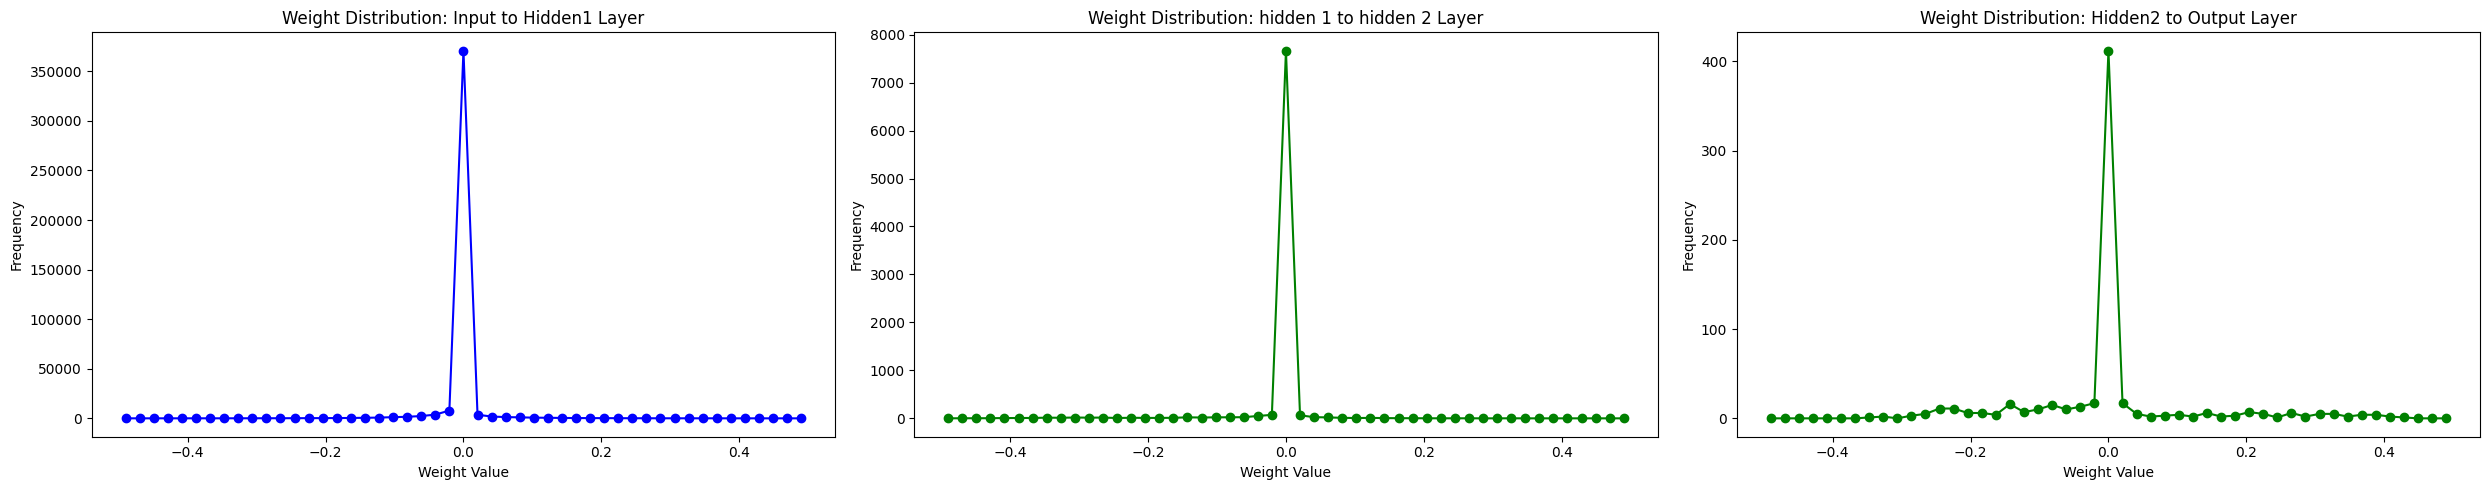

In [106]:
import matplotlib.pyplot as plt

fc_weights = model.fc.weight.cpu().detach().numpy().flatten()
fc2_weights = model.fc2.weight.cpu().detach().numpy().flatten()
out_weights = model.out.weight.cpu().detach().numpy().flatten()

bins = np.linspace(-0.5, 0.5, 50) 
fc_hist, fc_bins = np.histogram(fc_weights, bins=bins)
fc2_hist, fc2_bins = np.histogram(fc2_weights, bins=bins)
out_hist, out_bins = np.histogram(out_weights, bins=bins)

fc_bin_centers = 0.5 * (fc_bins[:-1] + fc_bins[1:])
fc2_bin_centers = 0.5 * (fc2_bins[:-1] + fc2_bins[1:])
out_bin_centers = 0.5 * (out_bins[:-1] + out_bins[1:])

plt.figure(figsize=(25, 5))

plt.subplot(1, 3, 1)
plt.plot(fc_bin_centers, fc_hist, marker='o', linestyle='-', color='b')
plt.title('Weight Distribution: Input to Hidden1 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.plot(fc2_bin_centers, fc2_hist, marker='o', linestyle='-', color='g')
plt.title('Weight Distribution: hidden 1 to hidden 2 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.plot(out_bin_centers, out_hist, marker='o', linestyle='-', color='g')
plt.title('Weight Distribution: Hidden2 to Output Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [107]:
import torch

def count_nonzero_weights_above_threshold(layer, threshold=0.01):
    return torch.sum(torch.abs(layer.weight) > threshold).item()

threshold_value = 0.01 

nonzero_fc1 = count_nonzero_weights_above_threshold(model.fc, threshold=threshold_value)
nonzero_fc2 = count_nonzero_weights_above_threshold(model.fc2, threshold=threshold_value)
nonzero_fc3 = count_nonzero_weights_above_threshold(model.out, threshold=threshold_value)

print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_fc1}')
print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_fc2}')
print(f'Number of non-zero weights greater than {threshold_value} in layer 3: {nonzero_fc3}')

Number of non-zero weights greater than 0.01 in layer 1: 30860
Number of non-zero weights greater than 0.01 in layer 1: 530
Number of non-zero weights greater than 0.01 in layer 3: 229


In [108]:
for i in range(len(lay)):
    if i > 0 and i <= len(lay)-1:
        norms = []
        for j in range(lay[i-1][1].weight.shape[0]):
            norms.append(np.sqrt(torch.sum(torch.square(lay[i][1].weight.data[:,j])).item())/np.sqrt(torch.sum(torch.square(lay[i-1][1].weight.data[j])).item()))
        print(norms)
        norms = torch.tensor(norms)
        print(norms.shape)

[569649785406.5098, 0.17926228546330455, 17677.189108330185, inf, 1.1013411086293408e+19, 1.0252522308794707, 40013.87639456929, 2610094492.0596156, 623888286630083.2, 0.6604643774196817, 1.6847860084212644e+16, 11789369778608.762, 8949583439636.258, 1.9589140127564102, inf, 891348.5974550701, 0.3189321309608093, 37.14062180422891, inf, 2173733336017301.8, inf, 0.4759232648260645, 2570827.72357809, 34701249017.39661, 0.8241566970781756, 0.2950548076562593, 1599925.7148095495, 6523493713.793565, 89526.6678824236, 5041952353519357.0, 55.99589410004276, 1.0012773042700036, 7925.849228157426, 0.6994183692005381, 4020934467.98121, 222267002078783.34, 23.44230820894029, 11871477.851667223, 3019629610.7416706, 450.67640699564396, 915.067586985219, 2.344637265554626, 0.229332324641709, 10362970179.093113, 7.396416409106632, 0.6567634113426578, 587695.1844919968, 2.513145961211261e+17, 91.5726184448618, 0.18047458971921349, 1839.4016644583485, 201.72777857180284, 0.450270178992654, 988451097.50

/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_62951/2415192822.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  norms.append(np.sqrt(torch.sum(torch.square(lay[i][1].weight.data[:,j])).item())/np.sqrt(torch.sum(torch.square(lay[i-1][1].weight.data[j])).item()))


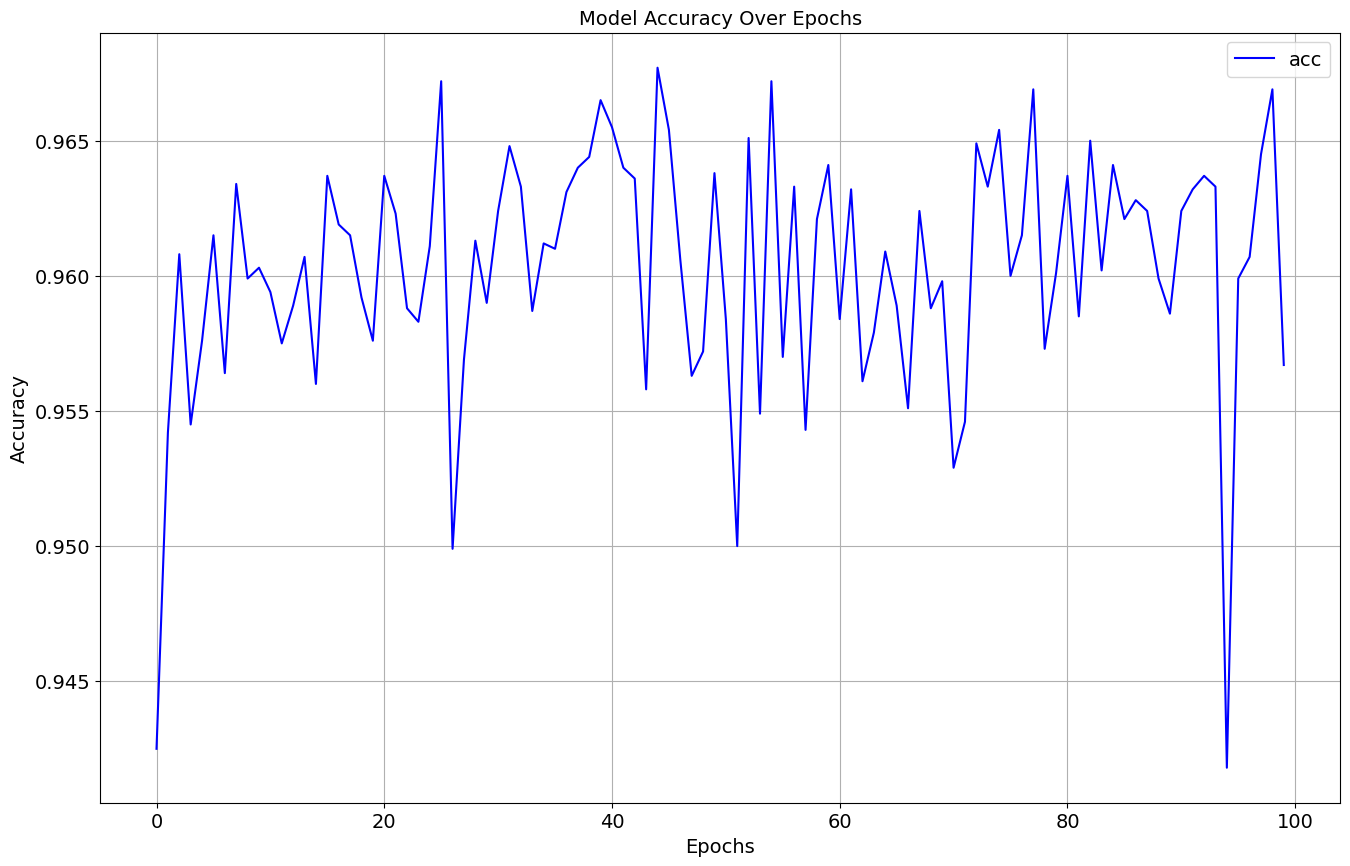

In [109]:
epochs_plot = list(range(100))

plt.figure(figsize=(16, 10))
plt.plot(epochs_plot, acc, linestyle='-', color='b', label='acc')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Model Accuracy Over Epochs', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True)

plt.legend(fontsize=14)

plt.show()

In [110]:
import pickle
with open('l2regularization4.pkl', 'wb') as f:
    pickle.dump(acc, f)

torch.save(model.state_dict(), 'l2Model4.pt')